<a href="https://colab.research.google.com/github/art-glazunov/MegaFon_RecSys_Workshop/blob/main/Part_4_2_Hybrid_recommender_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MegaFon RecSys workshop
by Artyom Glazunov

## Part 4.2. Hybrid recommender embeddings

## The plan

- ### Data and model loading
- ### Useful classes and methods
- ### Some preparations...
- ### Bonus: light fm methods investigation
- ### Embeddings plot
  - #### T-SNE method
  - #### UMAP method

In [ ]:
pip install -q lightfm==1.16

     |████████████████████████████████| 310 kB 5.1 MB/s 


In [ ]:
pip install umap-learn -q

     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 41.6 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.base import TransformerMixin, BaseEstimator

import lightfm
from lightfm import data

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap

import pickle
import warnings

### Data and model loading

In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks/datafest_22/data

/content/drive/MyDrive/Colab_Notebooks/datafest_22/data


In [ ]:
data_train_all = pd.read_csv("train.csv")
data_train_pos = pd.read_csv("train_pos.csv")
cold_items_data = pd.read_csv("cold_items_data.csv")

In [ ]:
!du -sh ../models/lfm_model.pkl

203M	../models/lfm_model.pkl


In [ ]:
with open("../models/lfm_model.pkl", "rb") as fin:
    model = pickle.load(fin)

### Useful classes and methods

In [ ]:
class ColumnCategorizer(TransformerMixin, BaseEstimator):
    """Creates new categorical features using continuous columns
    
    Requires 
    - quantiles list
    - columns to transform
    - new columns names
    """
    

    def __init__(self, qs, new_columns, old_columns):
        self.qs = qs #quantile list
        self.new_columns = new_columns #columns to create
        self.old_columns = old_columns #initial continuous columns
        self.transformers = {} #transformers storage
        

    def fit(self, X, y=None):
        """Fit transformers on a part of the columns
        X - train data
        """
        
        for column in self.old_columns:
            bins = np.unique([X[column].quantile(q=q) for q in self.qs])
            labels = [f"{column}_bin_{l_edge}_{r_edge}" for (l_edge, r_edge) in zip(bins[:-1], bins[1:])]
            self.transformers[column] = sklearn.preprocessing.FunctionTransformer(
                                             pd.cut, kw_args={'bins': bins, 
                                                              'include_lowest': True,
                                                              'labels': labels, 
                                                              'retbins': False}
                                                              ) 
            self.transformers[column].fit(X[column])
        return self
    

    def transform(self, X):
        """Transform data and return Pandas DataFrame
        X - data to transform
        """
        
        data_new = X.copy()
        for column_old, column_new in zip(self.old_columns, self.new_columns):
            data_new[column_new] = self.transformers[column_old].transform(data_new[column_old]).values
        return data_new


def names_to_cats(data_to_transform, cols):
    """Transform numeric categories using names of features
    
    data_to_transform - data to transform
    cols - columns to change
    """


    data_new = data_to_transform.copy()
    for col in cols:
        data_new[col] = data_new[col].apply(lambda x: f"{col}_{x}").values
    return data_new


def lfm_train_preprocessing(data_train, 
                            categorizer,
                            cat_cols_to_change,
                            user_fe_cols,
                            item_fe_cols,
                            user_id_column,
                            item_id_column,
                            user_identity_features=True,
                            item_identity_features=True):
    """Get all the object needed for the lfm model training

    data_train - train_data
    categorizer - numeric columns categorizer object
    cat_cols_to_change - columns to change via names_to_cats() method
    user_fe_cols - user features columns WITHOUT the id columns
    item_fe_cols - item features columns WITHOUT the id columns
    user_id_column - user id column
    item_id_column - item id column
    user_identity_features - consider user id as a feature?
    item_identity_features - consider item id as a feature?
    """

    data_prep = categorizer.transform(names_to_cats(data_train, cat_cols_to_change))

    user_fe_data = data_prep[user_fe_cols].values
    item_fe_data = data_prep[item_fe_cols].values
    user_id = data_prep[user_id_column].values.ravel()
    item_id = data_prep[item_id_column].values.ravel()


    dataset = data.Dataset(user_identity_features=user_identity_features,
                           item_identity_features=item_identity_features)
    dataset.fit(users=user_id, items=item_id,
                user_features=user_fe_data.ravel(),
                item_features=item_fe_data.ravel())
    user_features = dataset.build_user_features(((x[0], x[1]) for x \
                                                    in zip(user_id, user_fe_data)))
    item_features = dataset.build_item_features(((x[0], x[1]) for x \
                                                    in zip(item_id, item_fe_data)))
    interactions, _ = dataset.build_interactions(((x[0], x[1]) for x \
                                                    in zip(user_id, item_id)))
    result = {"dataset" : dataset,
              "user_features": user_features,
              "item_features": item_features,
              "interactions": interactions}
    return result

In [ ]:
def get_mappings(dataset):
    """Prepare the mappings

    dataset - lightfm dataset object
    """
    result_dict = {}
    result_dict["user_id_mapping"] = dataset.mapping()[0]
    result_dict["item_id_mapping"] = dataset.mapping()[2]
    result_dict["user_fename_intid_mapping"] = dataset._user_feature_mapping
    result_dict["item_fename_intid_mapping"] = dataset._item_feature_mapping
    return result_dict


def get_cold_weights(data_val, fename_intid_mapping):
    """Get weights for COLD users/items

    data_val - our data with features
    fename_intid_mapping - mapping with ids and category names
    """

    row_ids = []
    col_ids = []
    for ind_r, features in enumerate(data_val.values):
        for cat_name in features:
            if cat_name in fename_intid_mapping:
                row_ids.append(ind_r)
                col_ids.append(fename_intid_mapping[cat_name])
    values = [1] * len(col_ids)

    result = sklearn.preprocessing.\
                      normalize(scipy.sparse.csr.\
                                csr_matrix((values, (row_ids, col_ids)),
                                            shape = (data_val.shape[0],
                                                    len(fename_intid_mapping))),
                                norm="l1", copy=False)
    return result


def get_id_weights_mapping(data_val, selected_cols, id_col, 
                           id_mapping, fename_intid_mapping, 
                           train_weights):
    """Get mapping with ids as keys
    and light fm sparse weights as values

    Brings hot and cold data and computes the weights matrix
    data_val - our data
    selected cols - column names WITH id column 
    id_col - user/item id column
    id_mapping - light fm external-internal id mapping
    fename_intid_mapping - mapping with ids and category names
    train_weights - weights from the train time (created via dataset object)
    """

    ids_set = data_val[id_col].unique()

    id_weights_mapping = {}
    cold_ids = []
    for ind in ids_set:
        if ind in id_mapping:
            id_weights_mapping[ind] = train_weights[id_mapping[ind]]
        else:
            cold_ids.append(ind)

    if len(cold_ids) > 0:
        data_select = data_val[selected_cols]
        data_cold = data_select[data_select[id_col].isin(cold_ids)].drop_duplicates()
        cold_weights = get_cold_weights(data_cold, fename_intid_mapping) 
        for ind, cold_entity in enumerate(data_cold[id_col]):
            id_weights_mapping[cold_entity] = cold_weights[ind]

    return id_weights_mapping


### Some preparations...

In [ ]:
# Assign lists of features for training the lightfm dataset object
user_fe_cols = []
item_fe_cols = ["genre_ids", "artist_name", "composer", "language"]
user_id_column = "msno"
item_id_column = "song_id"

#Other lists of features
cat_cols_to_change = ["genre_ids", "language"] #columns to add name to value
numeric_cols = [] #this columns will be categorized

#Columns in the result dataframe with targets and scores
result_cols = [user_id_column, item_id_column, "target"]

#####
#quantile list for categorization
QS = np.linspace(0, 1, 11, endpoint=True)
#####

#only a patch here (for the correct work of the interfaces)
categorizer = ColumnCategorizer(qs=QS, 
                                new_columns=numeric_cols, 
                                old_columns=numeric_cols)
categorizer.fit(data_train_all)

ColumnCategorizer(new_columns=[], old_columns=[],
                  qs=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [ ]:
%%time
prep_dict = lfm_train_preprocessing(data_train_pos,
                                    categorizer=categorizer,
                                    cat_cols_to_change=cat_cols_to_change,
                                    user_fe_cols=user_fe_cols,
                                    item_fe_cols=item_fe_cols,
                                    user_id_column=user_id_column,
                                    item_id_column=item_id_column,
                                    user_identity_features=True,
                                    item_identity_features=False)
dataset = prep_dict["dataset"]
user_features = prep_dict["user_features"]
item_features = prep_dict["item_features"]

CPU times: user 43.2 s, sys: 1.13 s, total: 44.4 s
Wall time: 44.4 s


In [ ]:
mappings = get_mappings(dataset)

### Bonus: light fm methods investigation

In [ ]:
scores_1 = model.predict(user_ids=np.array(range(10)),
                      user_features=user_features[:10],
                      item_ids=np.array(range(10)),
                      item_features=item_features[:10],
                      num_threads=4)
scores_1

array([-0.37840948,  2.3142552 ,  0.5447191 , -0.9091275 ,  2.213565  ,
        1.2794073 , -2.902737  , -2.5255973 ,  3.1168215 ,  2.17686   ],
      dtype=float32)

In [ ]:
user_vecs = model.get_user_representations(user_features[:10])[1]
user_biases = model.get_user_representations(user_features[:10])[0]
item_vecs = model.get_item_representations(item_features[:10])[1]
item_biases = model.get_item_representations(item_features[:10])[0]
scores2 = np.sum(user_vecs * item_vecs, axis=1) + user_biases + item_biases
scores2

array([-0.37840962,  2.3142557 ,  0.54471993, -0.90912765,  2.2135646 ,
        1.2794069 , -2.902739  , -2.525596  ,  3.1168213 ,  2.1768594 ],
      dtype=float32)

#### So, we can get the same scores in two different ways. This example shows how predict() and get...representations() methods work. And with get...representations() method we'll get our item embeddings.


*** Another way to get the vectors and biases - use embeddings of categories (remember the model inference graph). Let's check it out:

In [ ]:
len(mappings['item_fename_intid_mapping']) #the number of item categories in the model's vocab

64079

So, this is the source of the trained categories embeddings (!for all different item features categories in the vocab, for all item categorical features in the train data!, remember NLP:) 

In [ ]:
model.item_embeddings.shape 

(64079, 200)

Use linear combination for vectors (let's compare to check:)

In [ ]:
assert np.all(model.get_item_representations(item_features[:10])[1] == item_features[:10] @ model.item_embeddings)

And similarly for biases...

In [ ]:
model.item_biases.shape

(64079,)

In [ ]:
assert np.all(model.get_item_representations(item_features[:10])[0] == item_features[:10] @ model.item_biases)

This is the core of the model :)

###Embeddings plot
####Let's use our knowledge to create some additional useful methods for the embeddings investigation.

In [ ]:
def get_embeddings_s(lfm_model, item_id_weights_mapping):
    """Get scaled items embeddings from a sparse weights mapping 
    and the lightfm model

    lfm_model - light fm model
    item_id_weights_mapping - weights created via light fm dataset() object
    """

    result = []
    for key in item_id_weights_mapping:
        item_sparse_weights = item_id_weights_mapping[key]
        item_vec = model.get_item_representations(item_sparse_weights)[1][0]
        result.append(item_vec)
    result_s = StandardScaler().fit_transform(np.array(result))
    return result_s


def vis_lfm_embeddings(data_in, lfm_model, categorizer, reducer, selected_cols, 
                       item_id_column, cat_cols_to_change, smpl_size,
                       mappings, train_weights, popular_cls_num,
                       figsize, alpha, cluster_col):
    """Plot embeddings with reduced dimension

    data_in - initial dataframe
    lfm_model - light fm model
    categorizer - numeric columns categorizer object
    reducer - dimension reducer
    selected_cols - item features columns + id column
    item_id_column - item id column
    cat_cols_to_change - columns to change via names_to_cats() method
    smpl_size - the number of objects to plot embeddings for
    mappings - mappings from the light fm dataset object 
    train_weights - matrix from dataset.build_item_features() 
        method before the training
    popular_cls_num - number of classes to differ
    figsize - final picture size
    alpha - transparency coef
    cluster_col - the column to use for clustering, so
        different values -> different colors
    """

    warnings.filterwarnings("ignore")
    unique_data = data_in[selected_cols].drop_duplicates()[:smpl_size].copy()
    data_prep = categorizer.transform(names_to_cats(unique_data, 
                                                    cat_cols_to_change))
    item_id_weights_mapping = get_id_weights_mapping(data_prep, 
                                                    selected_cols=selected_cols,
                                                    id_col=item_id_column, 
                                                    id_mapping=mappings["item_id_mapping"], 
                                                    fename_intid_mapping=mappings["item_fename_intid_mapping"], 
                                                    train_weights=train_weights)
    
    embeddings = get_embeddings_s(lfm_model, item_id_weights_mapping)
    X = reducer.fit_transform(embeddings)

    most_popular_clusters = list(data_prep[cluster_col].value_counts()[:popular_cls_num].index)
    reduced_df = pd.DataFrame({'c1': X[:,0], 
                              'c2': X[:,1], 
                              cluster_col: data_prep[cluster_col].values})
    reduced_df["cls"] = reduced_df[cluster_col].apply(lambda x: x if x in most_popular_clusters else "other")

    plt.figure(figsize=figsize)
    sns.scatterplot(data=reduced_df, x="c1", y="c2", hue="cls", alpha=alpha)
    plt.grid();

###Let's look at some songs vectors with their genre

In [ ]:
######
SAMPLE_SIZE = 5000
######

#### T-SNE method

In [ ]:
reducer = TSNE(2, random_state=42)

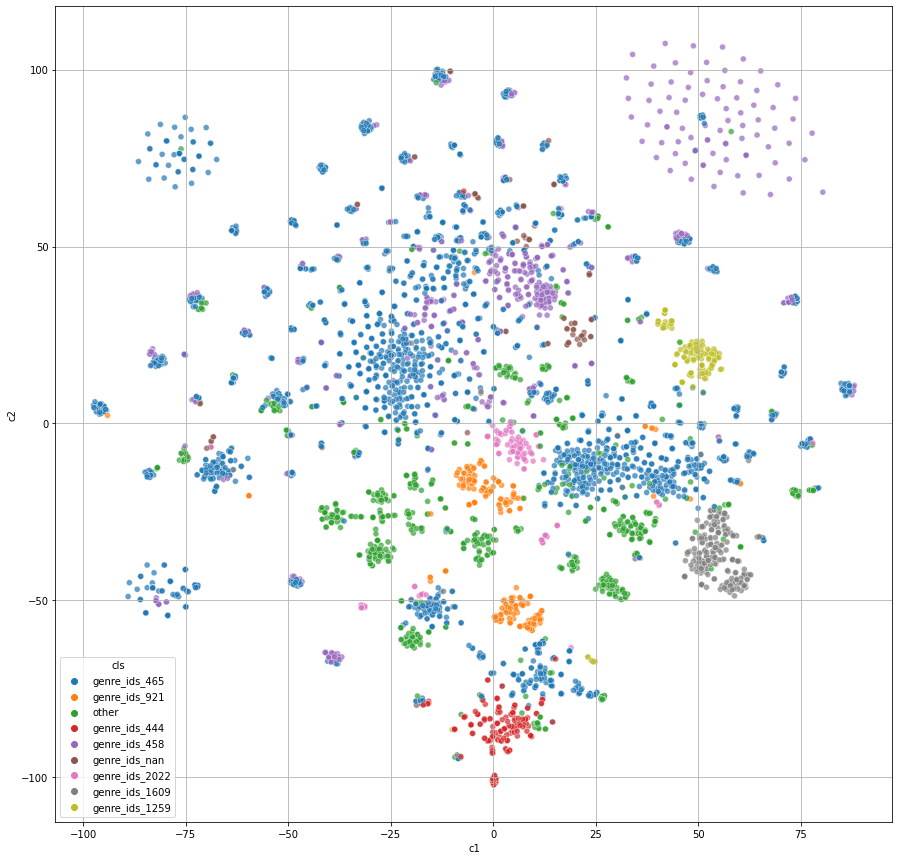

In [ ]:
vis_lfm_embeddings(data_train_pos, model, categorizer, reducer, 
                  item_fe_cols + [item_id_column], 
                  item_id_column, cat_cols_to_change, SAMPLE_SIZE,
                  mappings, item_features, 8,
                  (15, 15), 0.7, "genre_ids")

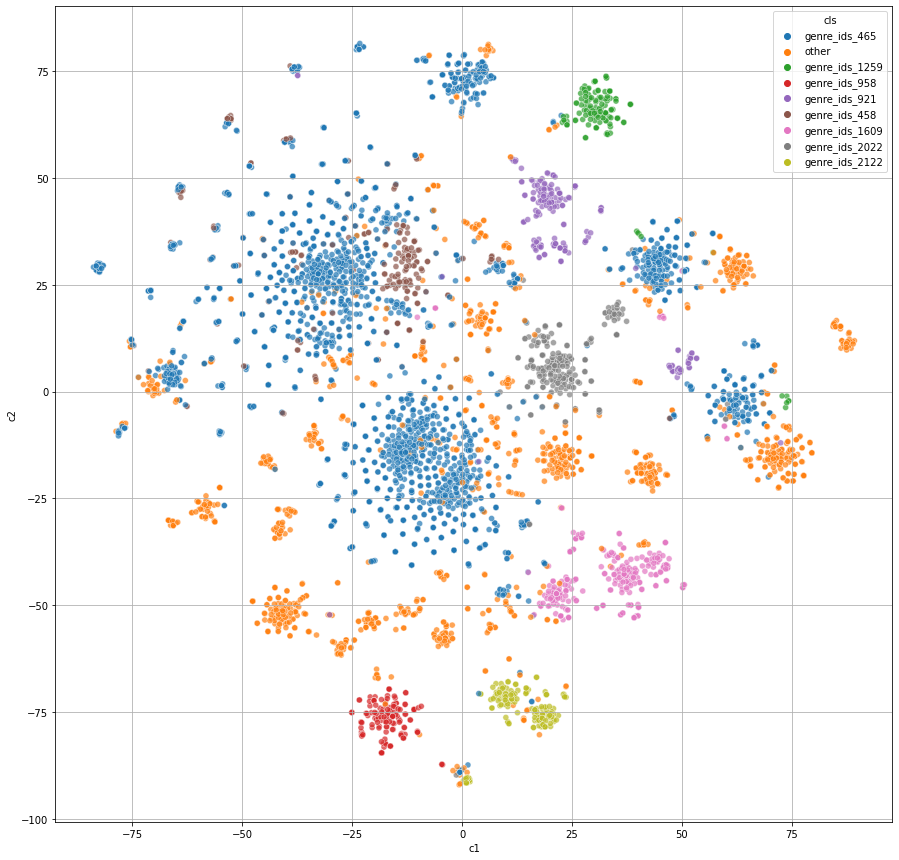

In [ ]:
vis_lfm_embeddings(cold_items_data, model, categorizer, reducer, 
                  item_fe_cols + [item_id_column], 
                  item_id_column, cat_cols_to_change, SAMPLE_SIZE,
                  mappings, item_features, 8,
                  (15, 15), 0.7, "genre_ids")

#### UMAP method

Let's try different metrics in the UMAP class

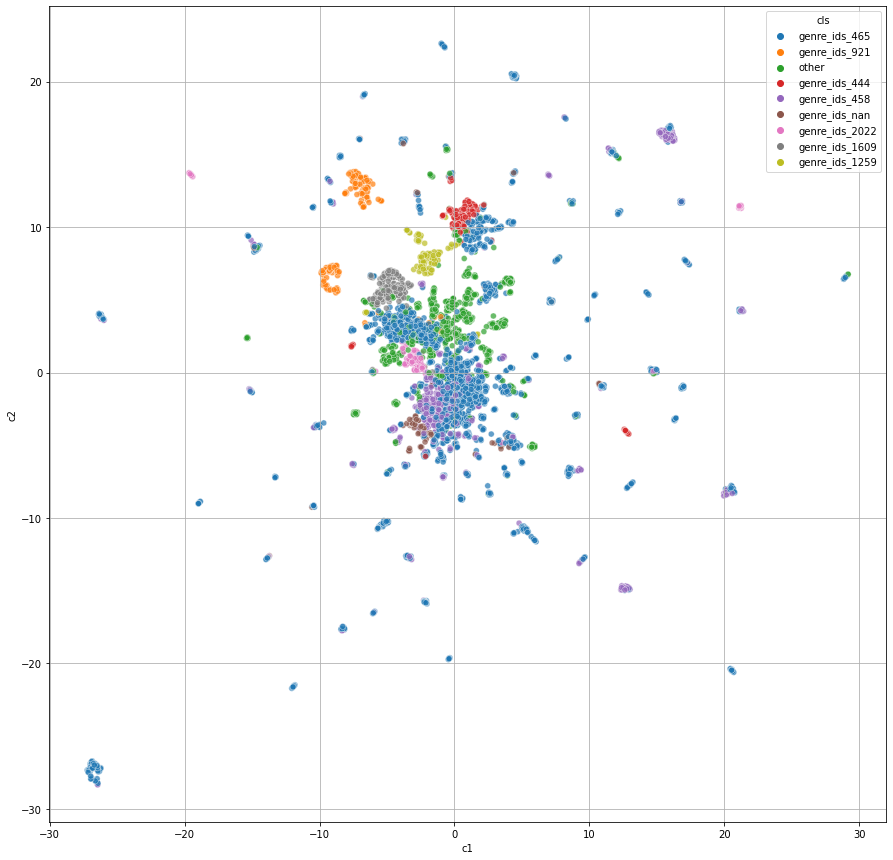

In [ ]:
reducer = umap.UMAP(n_neighbors=20,
                    min_dist=0.5,
                    n_components=2,
                    metric='euclidean',
                    random_state=42)
vis_lfm_embeddings(data_train_pos, model, categorizer, reducer, 
                  item_fe_cols + [item_id_column], 
                  item_id_column, cat_cols_to_change, SAMPLE_SIZE,
                  mappings, item_features, 8,
                  (15, 15), 0.7, "genre_ids")

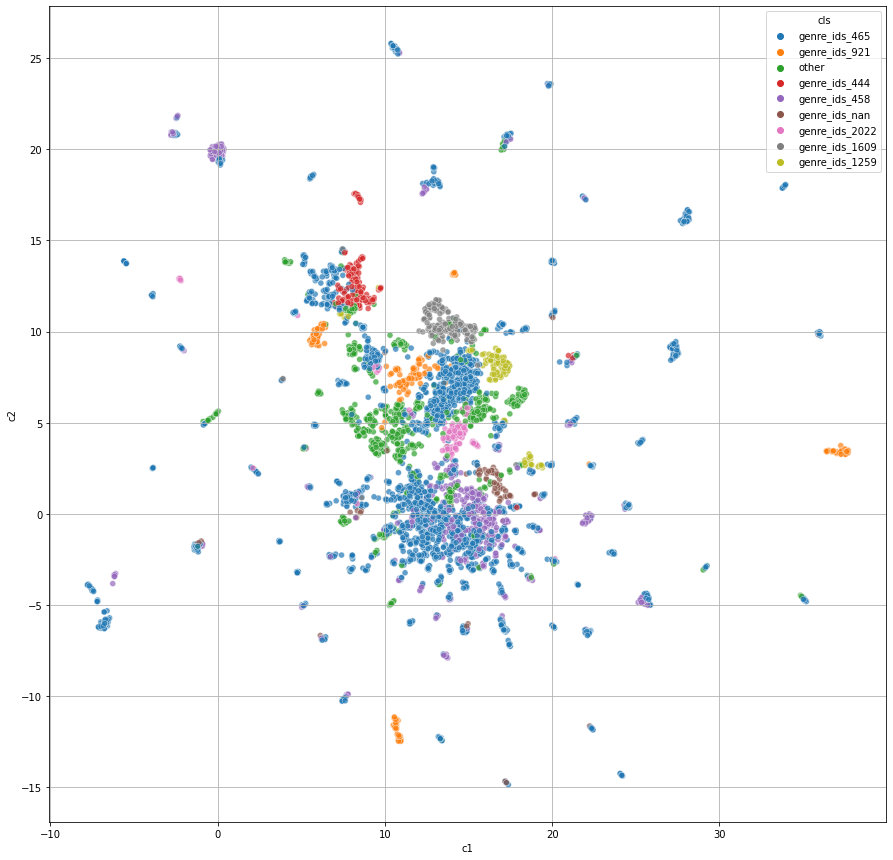

In [ ]:
reducer = umap.UMAP(n_neighbors=20,
                    min_dist=0.5,
                    n_components=2,
                    metric='cosine',
                    random_state=42)
vis_lfm_embeddings(data_train_pos, model, categorizer, reducer, 
                  item_fe_cols + [item_id_column], 
                  item_id_column, cat_cols_to_change, SAMPLE_SIZE,
                  mappings, item_features, 8,
                  (15, 15), 0.7, "genre_ids")

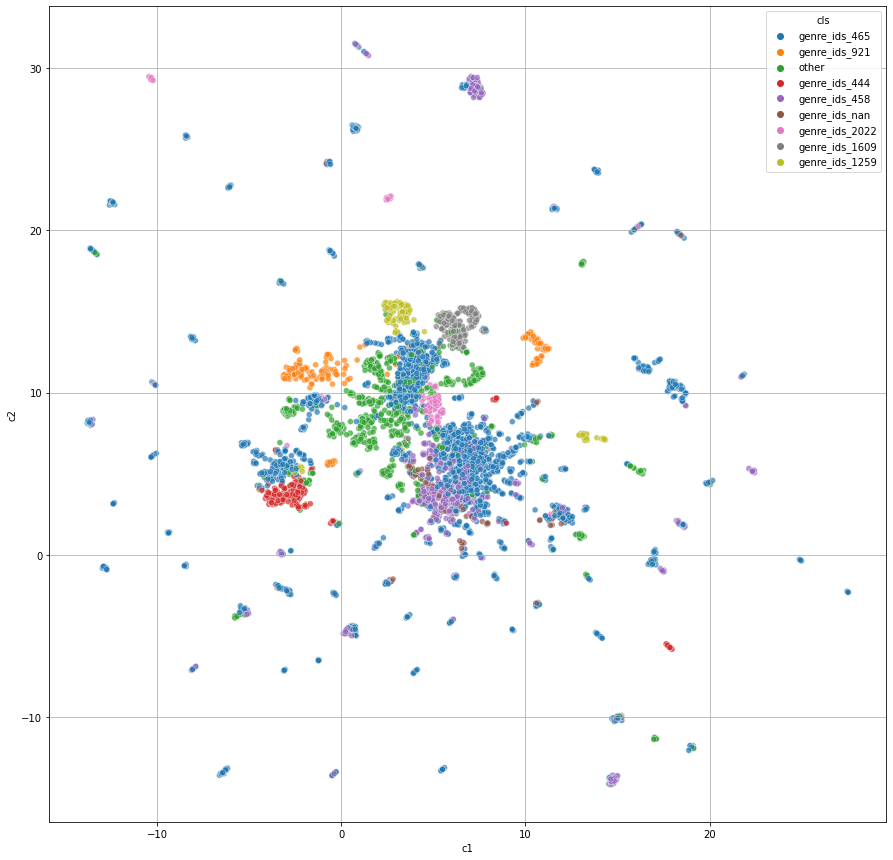

In [ ]:
reducer = umap.UMAP(n_neighbors=20,
                    min_dist=0.5,
                    n_components=2,
                    metric='manhattan',
                    random_state=42)
vis_lfm_embeddings(data_train_pos, model, categorizer, reducer, 
                  item_fe_cols + [item_id_column], 
                  item_id_column, cat_cols_to_change, SAMPLE_SIZE,
                  mappings, item_features, 8,
                  (15, 15), 0.7, "genre_ids")

### So, you can see that we have some clusters for hot and cold items.  At the same time, some genres are very similar.

### Stay tuned! :)